# SF Business Intelligence Platform - Data Exploration

This notebook is for exploring SF.gov Open Data and developing insights.

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path (project root /src)
cwd = Path.cwd()
for candidate in [cwd / "src", cwd.parent / "src", cwd.parent.parent / "src"]:
    if candidate.exists():
        sys.path.insert(0, str(candidate))
        print("Added to sys.path:", candidate)
        break
else:
    raise FileNotFoundError("Could not find a 'src' directory from current working dir")

# Force reload modules to pick up any code changes
for mod in list(sys.modules.keys()):
    if any(x in mod for x in ['data_pipeline', 'utils', 'risk_engine', 'city_intelligence', 'lease_intelligence']):
        del sys.modules[mod]

# Package imports from src
from data_pipeline import (
    download_business_registry,
    download_permits,
    download_complaints,
)
from data_pipeline.clean import clean_business_data
from data_pipeline.merge import merge_datasets
from utils.config import Config

print("Using dataset IDs:")
print(f"  Business: {Config.BUSINESS_LICENSE_DATASET}")
print(f"  Permits:  {Config.PERMITS_DATASET}")
print(f"  Complaints: {Config.COMPLAINTS_DATASET}")

Added to sys.path: /Users/dhruv/SJSU/Nvidia_hack/slowcal/src
Using dataset IDs:
  Business: g8m3-pdis
  Permits:  i98e-djp9
  Complaints: vw6y-z8j6
Using dataset IDs:
  Business: g8m3-pdis
  Permits:  i98e-djp9
  Complaints: vw6y-z8j6


## Download Data

In [2]:
# Download business registry data
try:
    business_df = download_business_registry()
    print(f"Downloaded {len(business_df)} business records")
    print(f"Columns: {list(business_df.columns)}")
    print(business_df.info())
except Exception as e:
    print("Business registry download failed:", e)
    cached = Config.RAW_DATA_DIR / "business_registry.json"
    if cached.exists():
        business_df = pd.read_json(cached, orient="records")
        print("Loaded cached business_registry.json:", len(business_df), "records")
    else:
        raise

Downloaded 50000 business records
Columns: ['uniqueid', 'certificate_number', 'ttxid', 'ownership_name', 'dba_name', 'full_business_address', 'city', 'state', 'business_zip', 'dba_start_date', 'dba_end_date', 'location_start_date', 'location_end_date', 'administratively_closed', 'parking_tax', 'transient_occupancy_tax', 'location', 'data_as_of', 'data_loaded_at', 'neighborhoods_analysis_boundaries', 'supervisor_district', 'community_benefit_district', ':@computed_region_6qbp_sg9q', ':@computed_region_qgnn_b9vv', ':@computed_region_26cr_cadq', ':@computed_region_ajp5_b2md', ':@computed_region_jwn9_ihcz', 'mailing_address_1', 'mail_city', 'mail_state', 'mail_zipcode', 'naic_code', 'naic_code_description', 'naics_code_descriptions_list', 'business_corridor', 'lic', 'lic_code_description', 'lic_code_descriptions_list']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype   

In [3]:
# Download permits data
try:
    permits_df = download_permits()
    print(f"Downloaded {len(permits_df)} permit records")
except Exception as e:
    print("Permits download failed:", e)
    cached = Config.RAW_DATA_DIR / "permits.json"
    if cached.exists():
        permits_df = pd.read_json(cached, orient="records")
        print("Loaded cached permits.json:", len(permits_df), "records")
    else:
        raise

Downloaded 50000 permit records


In [4]:
# Download complaints data
try:
    complaints_df = download_complaints()
    print(f"Downloaded {len(complaints_df)} complaint records")
except Exception as e:
    print("Complaints download failed:", e)
    cached = Config.RAW_DATA_DIR / "complaints.json"
    if cached.exists():
        complaints_df = pd.read_json(cached, orient="records")
        print("Loaded cached complaints.json:", len(complaints_df), "records")
    else:
        raise

Downloaded 50000 complaint records


In [5]:
complaints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 52 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   service_request_id               50000 non-null  int64         
 1   requested_datetime               50000 non-null  object        
 2   closed_date                      49169 non-null  object        
 3   updated_datetime                 50000 non-null  object        
 4   status_description               50000 non-null  object        
 5   status_notes                     49902 non-null  object        
 6   agency_responsible               50000 non-null  object        
 7   service_name                     50000 non-null  object        
 8   service_subtype                  49999 non-null  object        
 9   service_details                  49261 non-null  object        
 10  address                          50000 non-null  object   

## Clean and Explore Data

In [6]:
# Clean business data
business_clean = clean_business_data(business_df, dataset_type='business')
business_clean.head()

,uniqueid,certificate_number,ttxid,ownership_name,dba_name,full_business_address,city,state,business_zip,dba_start_date,...,naics_code_descriptions_list,business_corridor,lic,lic_code_description,lic_code_descriptions_list,business_name,business_start_year,has_location,is_active,business_account_number
0,0408918-01-999-0408918,408918,0408918-01-999,Kumari Arun,Kumari Arun,1077 47th St Apt B,Oakland,CA,94608.0,2007-01-01,...,NaN,NaN,NaN,NaN,NaN,Kumari Arun,2007,True,False,408918
1,0433742-01-001-0433742,433742,0433742-01-001,Liverail Inc,Liverail Inc,55 2nd St 575,San Francisco,CA,94105.0,2008-05-16,...,NaN,NaN,NaN,NaN,NaN,Liverail Inc,2008,True,False,433742
2,0466172-01-999-0466172,466172,0466172-01-999,Wheeler Darren S,Horizon Plumbing,120 San Carlos Way,Novato,CA,94945.0,2012-02-06,...,NaN,NaN,NaN,NaN,NaN,Horizon Plumbing,2012,True,False,466172
3,1209270-01-191-1096639,1096639,1209270-01-191,Dung Tran,Dung Tran,755 E Capitol Ave Apt J102,Milpitas,CA,95035.0,2019-01-01,...,NaN,NaN,NaN,NaN,NaN,Dung Tran,2019,True,False,1096639
4,1247745-02-201-1112417,1112417,1247745-02-201,Surveymonkey Inc,Surveymonkey Inc,123 Mission St Fl 26,San Francisco,CA,94105.0,2019-09-03,...,"Professional, Scientific, and Technical Services",NaN,NaN,NaN,NaN,Surveymonkey Inc,2019,True,False,1112417


In [7]:
# Basic statistics
print("Business Registry Statistics:")
print(business_clean.describe())
print("\nActive Businesses:", business_clean.get('is_active', pd.Series()).sum() if 'is_active' in business_clean.columns else 'N/A')

Business Registry Statistics:
       certificate_number  business_zip                 dba_start_date  \
count        5.000000e+04  49866.000000                          50000   
mean         7.687750e+05  92746.606525  2011-05-09 14:32:03.839999744   
min          8.600000e+01    802.000000            1849-09-01 00:00:00   
25%          4.302725e+05  94107.000000            2007-01-19 00:00:00   
50%          1.007640e+06  94112.000000            2014-03-03 00:00:00   
75%          1.100141e+06  94124.000000            2018-11-04 06:00:00   
max          1.178605e+06  99999.000000            2026-01-23 00:00:00   
std          3.637705e+05   9899.481527                            NaN   

                        dba_end_date         location_start_date  \
count                          27152                       50000   
mean   2019-04-15 00:38:04.737772800  2013-10-14 16:31:26.400000   
min              1907-01-01 00:00:00         1849-09-01 00:00:00   
25%              2017-03-02 00:

## Merge Datasets

In [8]:
# Clean other datasets
permits_clean = clean_business_data(permits_df, dataset_type='permits')
complaints_clean = clean_business_data(complaints_df, dataset_type='complaints')

# Merge
merged_df = merge_datasets(business_clean, permits_clean, complaints_clean)
print(f"Merged dataset: {len(merged_df)} records")
merged_df.head()

No common key 'business_account_number' for permits merge. Adding summary stats.
No common key 'business_account_number' for complaints merge. Adding summary stats.
No common key 'business_account_number' for complaints merge. Adding summary stats.


Merged dataset: 50000 records


,uniqueid,certificate_number,ttxid,ownership_name,dba_name,full_business_address,city,state,business_zip,dba_start_date,...,business_account_number,total_permits,total_permit_cost,avg_permit_cost,total_complaints,closed_complaints,open_complaints,has_permits,has_complaints,complaint_rate
0,0408918-01-999-0408918,408918,0408918-01-999,Kumari Arun,Kumari Arun,1077 47th St Apt B,Oakland,CA,94608.0,2007-01-01,...,408918,0.0,0.0,0.0,0,0,0,False,False,0.0
1,0433742-01-001-0433742,433742,0433742-01-001,Liverail Inc,Liverail Inc,55 2nd St 575,San Francisco,CA,94105.0,2008-05-16,...,433742,1654.0,0.0,0.0,0,0,0,True,False,0.0
2,0466172-01-999-0466172,466172,0466172-01-999,Wheeler Darren S,Horizon Plumbing,120 San Carlos Way,Novato,CA,94945.0,2012-02-06,...,466172,0.0,0.0,0.0,0,0,0,False,False,0.0
3,1209270-01-191-1096639,1096639,1209270-01-191,Dung Tran,Dung Tran,755 E Capitol Ave Apt J102,Milpitas,CA,95035.0,2019-01-01,...,1096639,0.0,0.0,0.0,0,0,0,False,False,0.0
4,1247745-02-201-1112417,1112417,1247745-02-201,Surveymonkey Inc,Surveymonkey Inc,123 Mission St Fl 26,San Francisco,CA,94105.0,2019-09-03,...,1112417,1654.0,0.0,0.0,0,0,0,True,False,0.0


## Visualizations

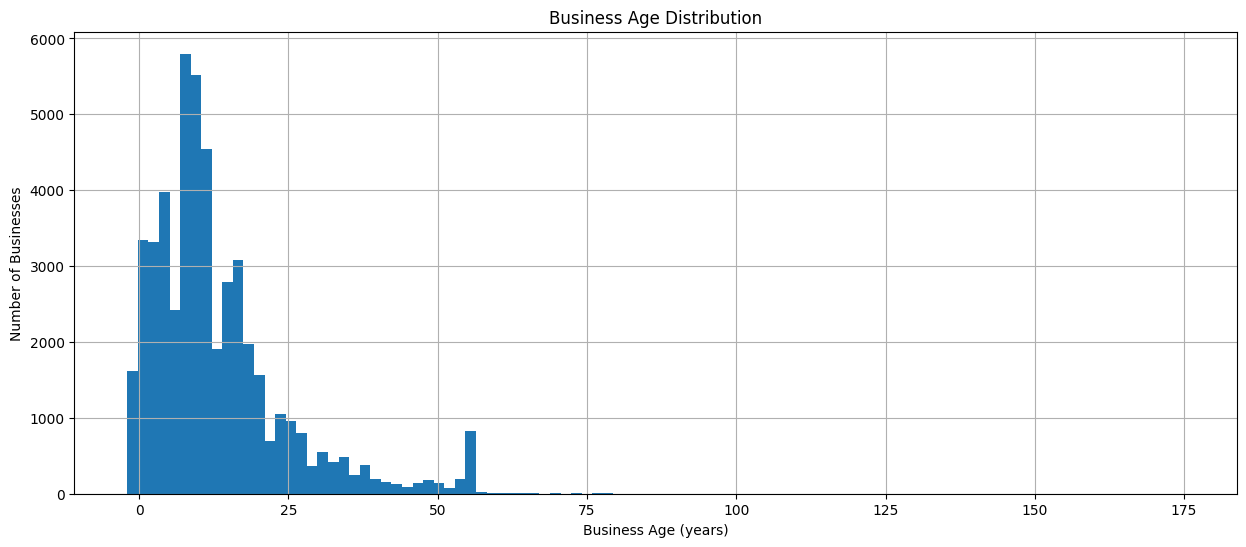

In [9]:
# Business age distribution
if 'business_start_year' in merged_df.columns:
    merged_df['business_age'] = 2024 - merged_df['business_start_year']
    plt.figure(figsize=(15, 6))
    merged_df['business_age'].hist(bins=100)
    plt.title('Business Age Distribution')
    plt.xlabel('Business Age (years)')
    plt.ylabel('Number of Businesses')
    plt.show()

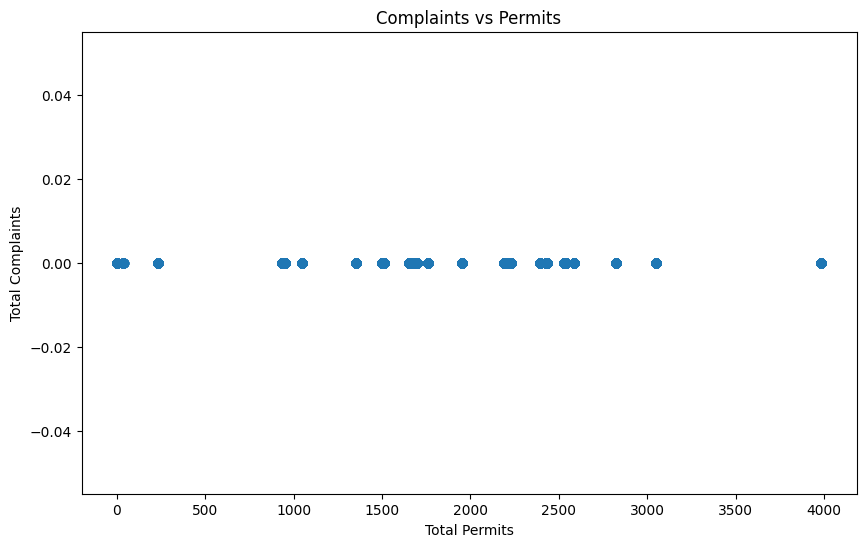

In [10]:
# Complaints vs Permits
if 'total_complaints' in merged_df.columns and 'total_permits' in merged_df.columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_df['total_permits'], merged_df['total_complaints'], alpha=0.5)
    plt.xlabel('Total Permits')
    plt.ylabel('Total Complaints')
    plt.title('Complaints vs Permits')
    plt.show()

## Risk Model Exploration

In [11]:
from risk_engine.model import RiskPredictor

# Initialize and train model
predictor = RiskPredictor(model_type='random_forest')
metrics = predictor.train(merged_df)

print("Model Training Metrics:")
print(f"ROC-AUC: {metrics['roc_auc']:.3f}")

Model Training Metrics:
ROC-AUC: 1.000


In [12]:
# Feature importance
feature_importance = predictor.get_feature_importance()
print("Top Risk Factors:")
print(feature_importance.head(10))

Top Risk Factors:
             feature  importance
1          is_active    0.828978
0       business_age    0.108649
3      total_permits    0.037655
4        has_permits    0.024466
2       has_location    0.000252
5   total_complaints    0.000000
6    open_complaints    0.000000
7     has_complaints    0.000000
8     complaint_rate    0.000000
9  total_permit_cost    0.000000


In [13]:
# Predictions
predictions = predictor.predict(merged_df)
print(f"Risk Score Distribution:")
print(predictions['risk_score'].describe())
print(f"\nRisk Levels:")
print(predictions['risk_level'].value_counts())

Risk Score Distribution:
count    50000.000000
mean         0.682787
std          0.460281
min          0.000000
25%          0.010043
50%          0.992031
75%          1.000000
max          1.000000
Name: risk_score, dtype: float64

Risk Levels:
risk_level
High      34227
Low       10008
Medium        0
Name: count, dtype: int64


## Improved Risk Model (Without Data Leakage)

The model above has **data leakage** - `is_active` is essentially the same as our target variable. Let's build a proper model that predicts business failure using only **predictive features** (not the outcome itself).

In [14]:
# Load raw data directly for proper feature engineering
import json
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
import joblib
import pandas as pd
import numpy as np

# Load raw JSON files
data_path = Path('../data/raw')

with open(data_path / 'business_registry.json', 'r') as f:
    business_raw = json.load(f)
    
with open(data_path / 'permits.json', 'r') as f:
    permits_raw = json.load(f)
    
with open(data_path / 'complaints.json', 'r') as f:
    complaints_raw = json.load(f)

print(f"Loaded {len(business_raw)} businesses, {len(permits_raw)} permits, {len(complaints_raw)} complaints")

Loaded 50000 businesses, 50000 permits, 50000 complaints


In [18]:
# Create proper business DataFrame with predictive features
biz_df = pd.DataFrame(business_raw)

# Parse dates to determine business status
biz_df['start_date'] = pd.to_datetime(biz_df.get('dba_start_date'), errors='coerce')
biz_df['end_date'] = pd.to_datetime(biz_df.get('dba_end_date'), errors='coerce')

# TARGET: Business is closed if it has an end date
biz_df['is_closed'] = biz_df['end_date'].notna().astype(int)

# FEATURES (predictive, not leaking the outcome)
current_year = 2025
biz_df['business_age'] = current_year - biz_df['start_date'].dt.year.fillna(current_year)

# Registration info features
biz_df['has_naic_code'] = biz_df.get('naic_code', '').notna().astype(int)
biz_df['has_parking_tax'] = (biz_df.get('parking_tax', '') == 'Y').astype(int)
biz_df['has_transient_tax'] = (biz_df.get('transient_occupancy_tax', '') == 'Y').astype(int)

# Neighborhood for aggregation
biz_df['neighborhood'] = biz_df.get('neighborhoods_analysis_boundaries', 'Unknown')

print("Business data shape:", biz_df.shape)
print(f"\nTarget distribution:")
print(biz_df['is_closed'].value_counts())

Business data shape: (50000, 46)

Target distribution:
is_closed
1    27152
0    22848
Name: count, dtype: int64


In [16]:
# Add neighborhood-level features from permits and complaints
permits_df_raw = pd.DataFrame(permits_raw)
complaints_df_raw = pd.DataFrame(complaints_raw)

# Aggregate permits by neighborhood (using correct column name)
permits_df_raw['neighborhood'] = permits_df_raw.get('neighborhoods_analysis_boundaries', pd.Series())
permits_df_raw['estimated_cost'] = pd.to_numeric(permits_df_raw.get('estimated_cost', 0), errors='coerce').fillna(0)

permit_agg = permits_df_raw[permits_df_raw['neighborhood'].notna()].groupby('neighborhood').agg({
    'permit_number': 'count',
    'estimated_cost': 'mean'
}).rename(columns={'permit_number': 'neighborhood_permits', 'estimated_cost': 'avg_permit_cost'}).reset_index()

print(f"Permit aggregation: {len(permit_agg)} neighborhoods")
print(permit_agg.head())

# Aggregate complaints by neighborhood  
complaints_df_raw['neighborhood'] = complaints_df_raw.get('neighborhoods_sffind_boundaries', pd.Series())

complaint_agg = complaints_df_raw[complaints_df_raw['neighborhood'].notna()].groupby('neighborhood').agg({
    'service_request_id': 'count'
}).rename(columns={'service_request_id': 'neighborhood_311_cases'}).reset_index()

print(f"\nComplaint aggregation: {len(complaint_agg)} neighborhoods")

# Merge aggregations with business data
biz_df = biz_df.merge(permit_agg, on='neighborhood', how='left')
biz_df = biz_df.merge(complaint_agg, on='neighborhood', how='left')

# Fill missing values
biz_df['neighborhood_permits'] = biz_df['neighborhood_permits'].fillna(0)
biz_df['avg_permit_cost'] = biz_df['avg_permit_cost'].fillna(0)
biz_df['neighborhood_311_cases'] = biz_df['neighborhood_311_cases'].fillna(0)

print(f"\nMerged successfully!")
print(biz_df[['neighborhood', 'neighborhood_permits', 'avg_permit_cost', 'neighborhood_311_cases']].describe())

Features added!
                     neighborhood  neighborhood_permits  avg_permit_cost  \
0                             NaN                   0.0              0.0   
1  Financial District/South Beach                   0.0              0.0   
2                             NaN                   0.0              0.0   
3                             NaN                   0.0              0.0   
4  Financial District/South Beach                   0.0              0.0   

   neighborhood_311_cases  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0  


In [17]:
# Prepare feature matrix and target
feature_cols = [
    'business_age',
    'has_naic_code',
    'has_parking_tax', 
    'has_transient_tax',
    'neighborhood_permits',
    'avg_permit_cost',
    'neighborhood_311_cases'
]

# Drop rows with missing values in features
model_df = biz_df.dropna(subset=feature_cols + ['is_closed'])

X = model_df[feature_cols]
y = model_df['is_closed']

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"\nFeature statistics:")
print(X.describe())

Feature matrix shape: (50000, 7)
Target distribution: {1: 27152, 0: 22848}

Feature statistics:
       business_age  has_naic_code  has_parking_tax  has_transient_tax  \
count  50000.000000    50000.00000          50000.0            50000.0   
mean      14.069980        0.47644              0.0                0.0   
std       11.721199        0.49945              0.0                0.0   
min       -1.000000        0.00000              0.0                0.0   
25%        7.000000        0.00000              0.0                0.0   
50%       11.000000        0.00000              0.0                0.0   
75%       18.000000        1.00000              0.0                0.0   
max      176.000000        1.00000              0.0                0.0   

       neighborhood_permits  avg_permit_cost  neighborhood_311_cases  
count               50000.0          50000.0            50000.000000  
mean                    0.0              0.0              828.458280  
std                     

In [ ]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

In [ ]:
# Train Random Forest Model
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Evaluation Metrics
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Active', 'Closed']))

In [ ]:
# Feature Importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance (Proper Model):")
print(importance_df.to_string(index=False))

# Plot feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Business Risk Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Save the trained model
model_data = {
    'model': model,
    'scaler': scaler,
    'feature_names': feature_cols,
    'roc_auc': roc_auc
}

model_path = Path('../models')
model_path.mkdir(exist_ok=True)
joblib.dump(model_data, model_path / 'risk_model_v1.joblib')

print(f"Model saved to {model_path / 'risk_model_v1.joblib'}")

In [ ]:
# Add risk scores to all businesses and analyze risk distribution
model_df['risk_score'] = model.predict_proba(scaler.transform(model_df[feature_cols]))[:, 1]

# Categorize risk levels
def categorize_risk(score):
    if score < 0.4:
        return 'Low'
    elif score < 0.7:
        return 'Medium'
    else:
        return 'High'

model_df['risk_level'] = model_df['risk_score'].apply(categorize_risk)

print("Risk Level Distribution:")
print(model_df['risk_level'].value_counts())

# Show high-risk neighborhoods
high_risk = model_df[model_df['risk_level'] == 'High'].groupby('neighborhood').size().sort_values(ascending=False)
print(f"\nTop 10 Neighborhoods with High-Risk Businesses:")
print(high_risk.head(10))